In [1]:
# https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLOv3

In [2]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import time
import sys
sys.path.append('../')

import config
from model import YOLOv3
from dataset import PapsDataset, train_transforms, val_transforms
from train import  train_fn
from scheduler import CosineAnnealingWarmUpRestarts

from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss

In [3]:
partition = np.load('../data/partition.npy', allow_pickle=True, encoding='latin1').item()
label = np.load('../data/labels_info.npy', allow_pickle=True, encoding='latin1').item()
# partition['train'][0:2]

In [4]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

In [5]:
IMAGE_SIZE = config.IMAGE_SIZE
train_dataset = PapsDataset(
    label,partition['train'],
    transform=train_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    anchors=config.ANCHORS,
)
test_dataset = PapsDataset(
    label,partition['test'],
    transform=val_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    anchors=config.ANCHORS,
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    num_workers=config.NUM_WORKERS,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

In [6]:
images, targets = (next(iter(test_dataset)))
print(images.shape)
print(targets[0].shape)
print(targets[1].shape)
print(targets[2].shape)
# for i, j in train_dataset :
#     print(i)

torch.Size([3, 416, 416])
torch.Size([3, 13, 13, 6])
torch.Size([3, 26, 26, 6])
torch.Size([3, 52, 52, 6])


In [7]:
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
scaled_anchors.shape

torch.Size([3, 3, 2])

In [8]:
saved_dir = '../trained_model/'
state = torch.load(saved_dir + 'epoch_' + str(90) +'_model.pt')
epoch = state['epoch']
model.load_state_dict(state['state_dict'], strict=False)
optimizer.load_state_dict(state['optimizer'])
# scheduler.load_state_dict(state['scheduler'])

In [9]:
# model.eval()
# # check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
# pred_boxes, true_boxes = get_evaluation_bboxes(
#     test_loader,
#     model,
# #     iou_threshold=config.NMS_IOU_THRESH,
# #     anchors=config.ANCHORS,
# #     threshold=config.CONF_THRESHOLD,
#     iou_threshold=0.4,
#     anchors=config.ANCHORS,
#     threshold=0.5,    
# )
# mapval = mean_average_precision(
#     pred_boxes,
#     true_boxes,
#     iou_threshold=config.MAP_IOU_THRESH,
#     box_format="midpoint",
#     num_classes=config.NUM_CLASSES,
# )
# print(f"MAP: {mapval.item()}")

In [10]:
# x, y = next(iter(test_dataset))
# print((x.shape))
# # print(type(y))
# x, y = iter(test_loader).next()
# print((x.shape))
# # print(type(y))

In [11]:
# import matplotlib.pyplot as plt
# plot_couple_examples(model, test_loader, 0.5, 0.4, scaled_anchors)

In [12]:
# scaled_anchors[2]

In [13]:
# plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
# check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
# model.eval()
# pred_boxes, true_boxes = get_evaluation_bboxes(
#     test_loader,
#     model,
#     iou_threshold=config.NMS_IOU_THRESH,
#     anchors=config.ANCHORS,
#     threshold=config.CONF_THRESHOLD,
# )

100%|██████████| 3744/3744 [01:00<00:00, 61.60it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.493622%
Obj accuracy is: 90.820831%


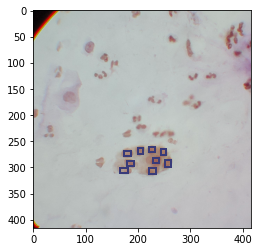

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [01:00<00:00, 62.34it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.370903%
Obj accuracy is: 92.687721%


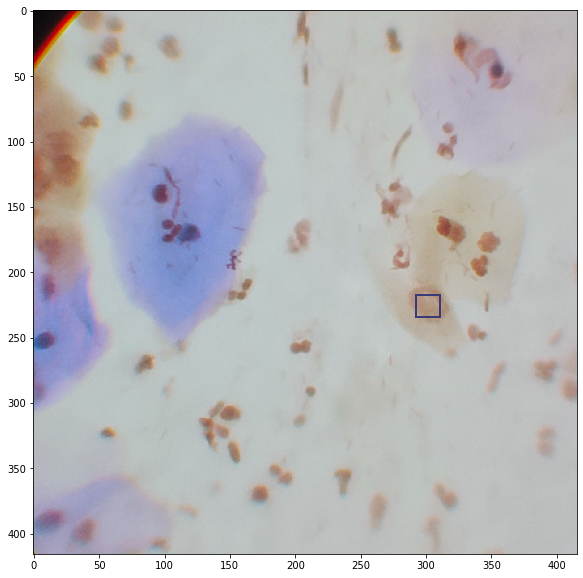

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [01:00<00:00, 61.68it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.456802%
Obj accuracy is: 90.974220%


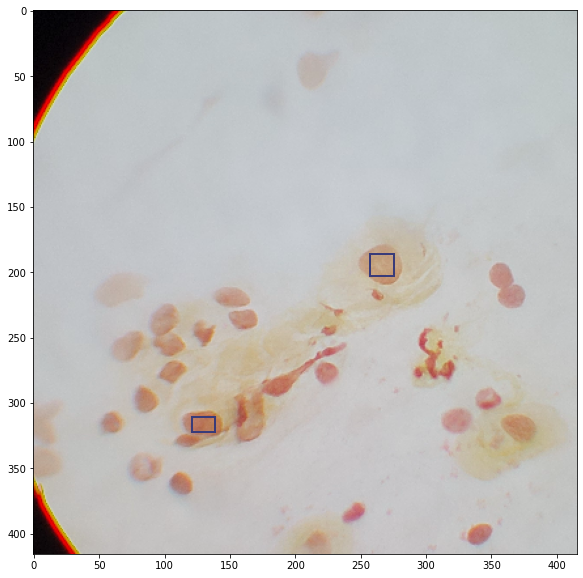

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [01:00<00:00, 62.36it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.531113%
Obj accuracy is: 88.918404%


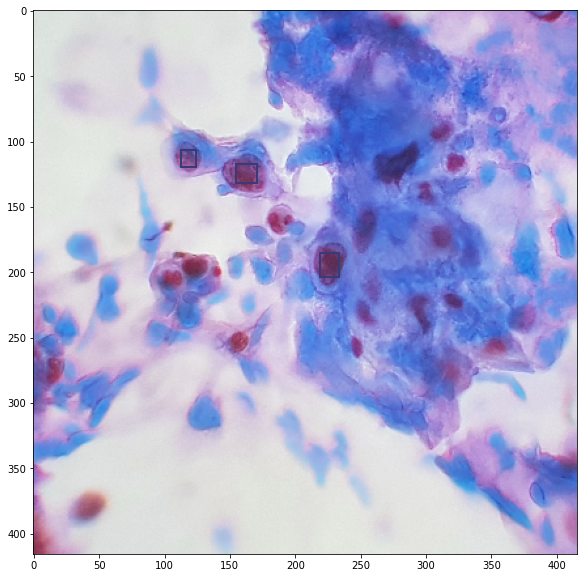

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:59<00:00, 63.39it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.530075%
Obj accuracy is: 90.401810%


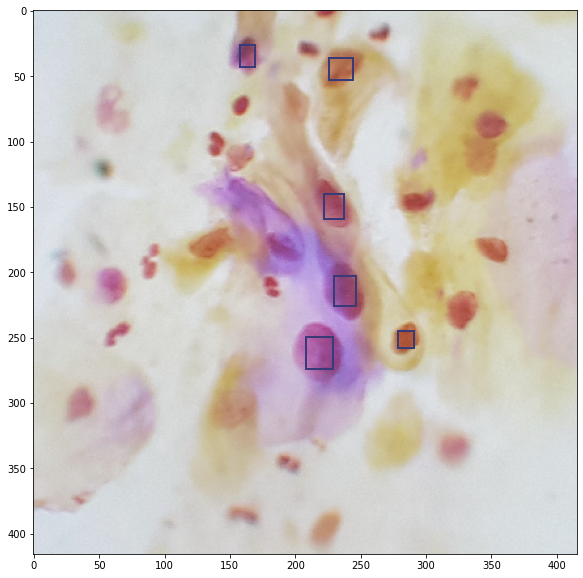

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:59<00:00, 63.25it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.465302%
Obj accuracy is: 92.162071%


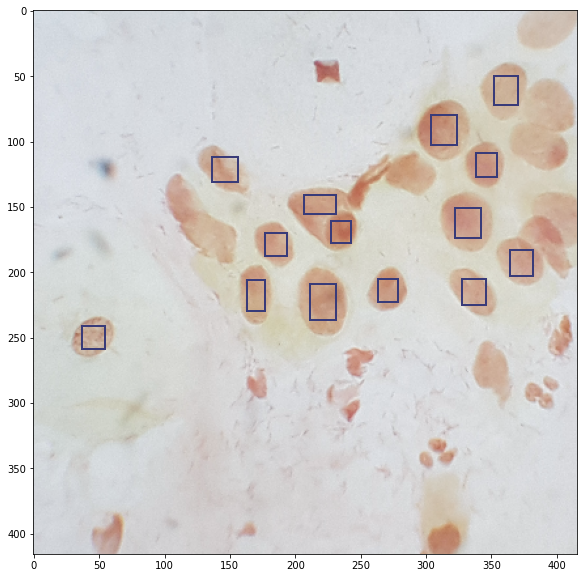

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:59<00:00, 63.26it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.566544%
Obj accuracy is: 90.605713%


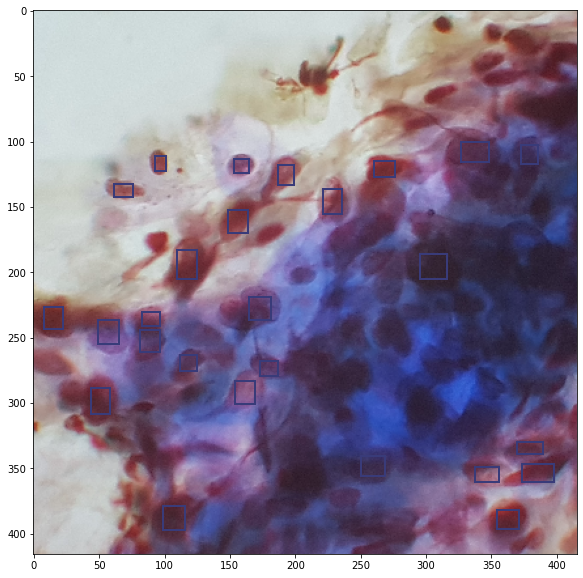

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:59<00:00, 63.40it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.575317%
Obj accuracy is: 90.648735%


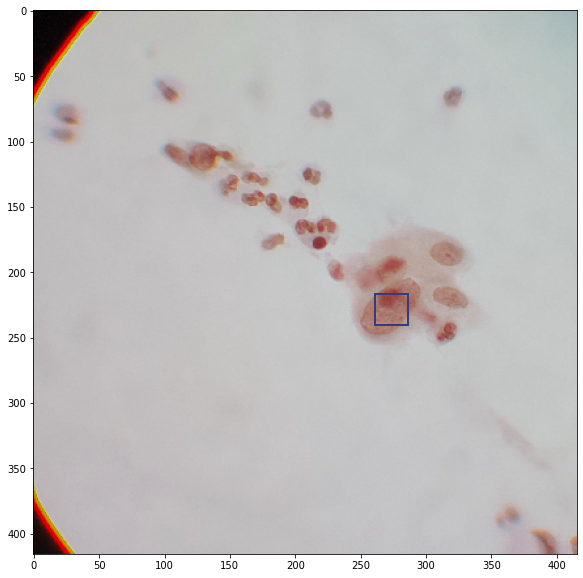

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [01:00<00:00, 62.37it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.605614%
Obj accuracy is: 89.689102%


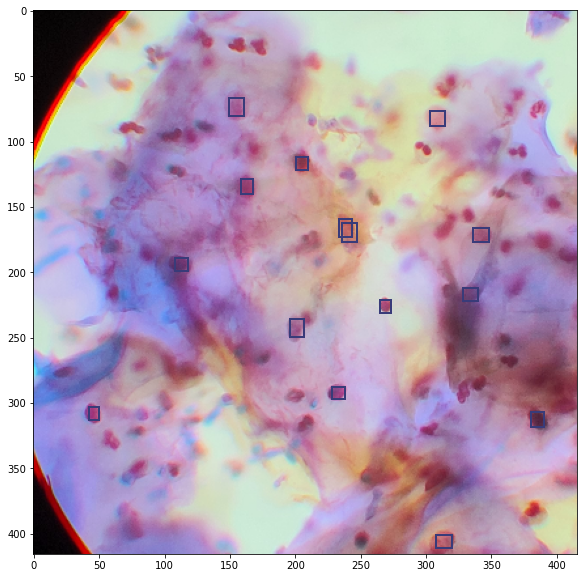

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:59<00:00, 63.40it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.618759%
Obj accuracy is: 89.853714%


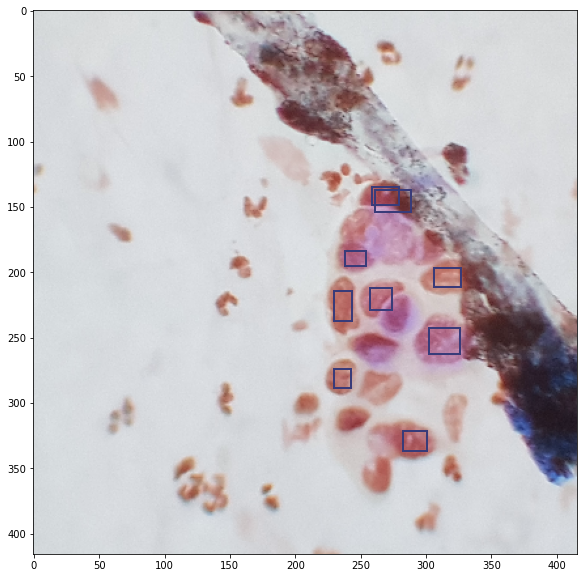

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:59<00:00, 63.20it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.547089%
Obj accuracy is: 91.608360%


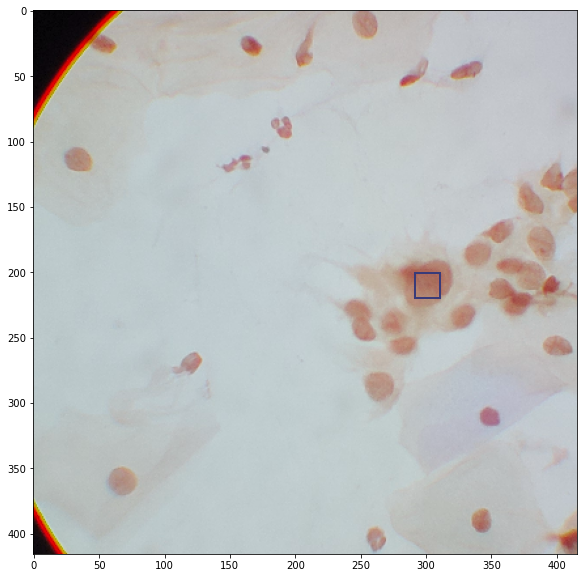

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:58<00:00, 63.69it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.617447%
Obj accuracy is: 90.899399%


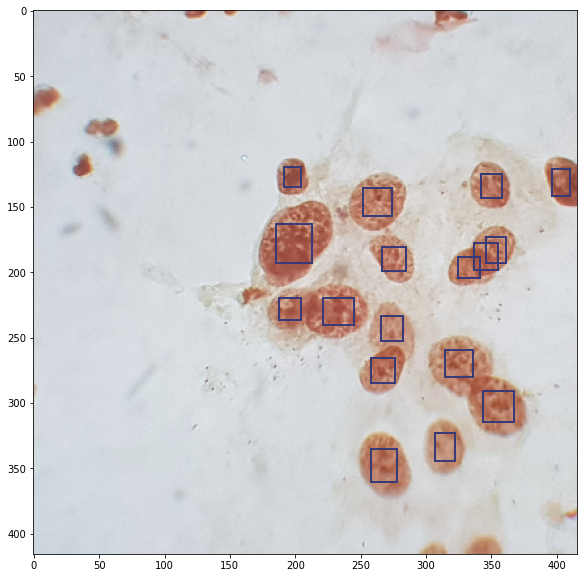

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:58<00:00, 63.51it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.624191%
Obj accuracy is: 90.444832%


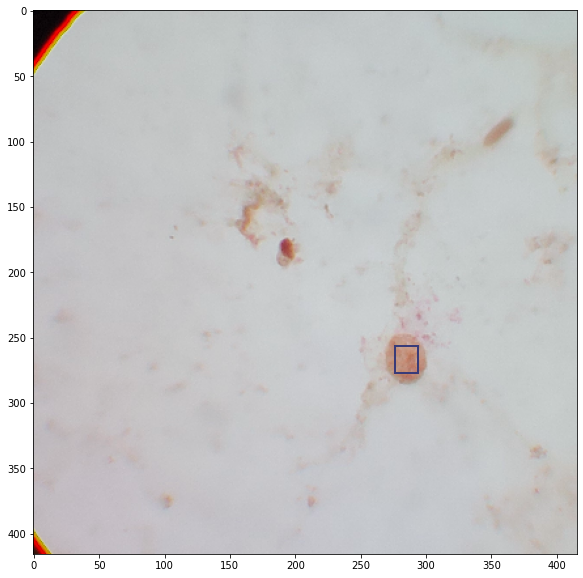

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:58<00:00, 63.71it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.636177%
Obj accuracy is: 90.600098%


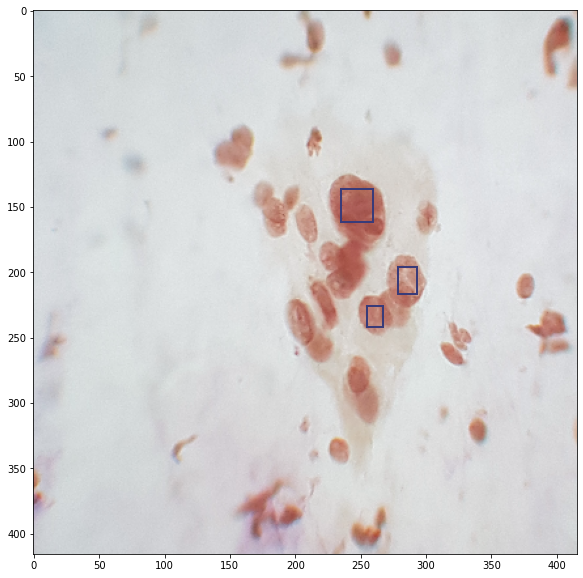

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:58<00:00, 63.54it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.657372%
Obj accuracy is: 90.334473%


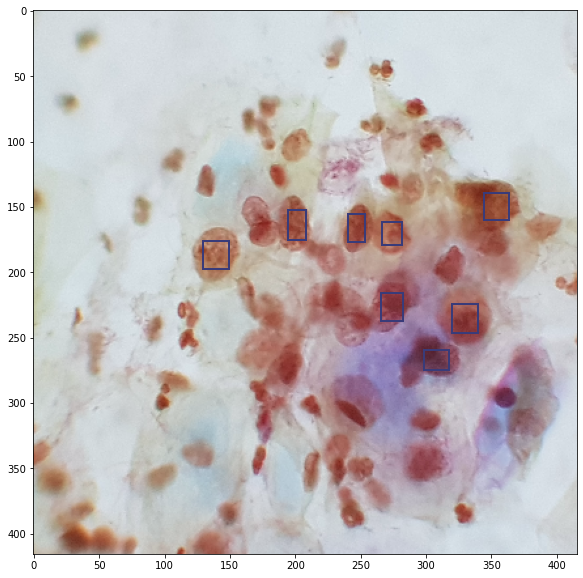

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [01:03<00:00, 58.90it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.647575%
Obj accuracy is: 90.555206%


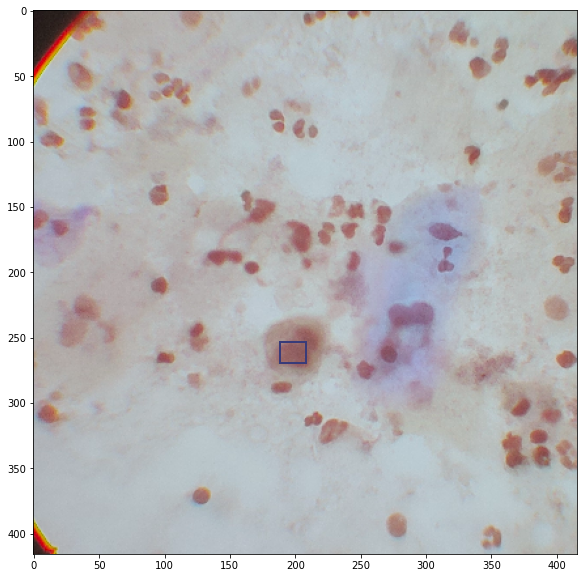

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [01:02<00:00, 60.15it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.567177%
Obj accuracy is: 92.521233%


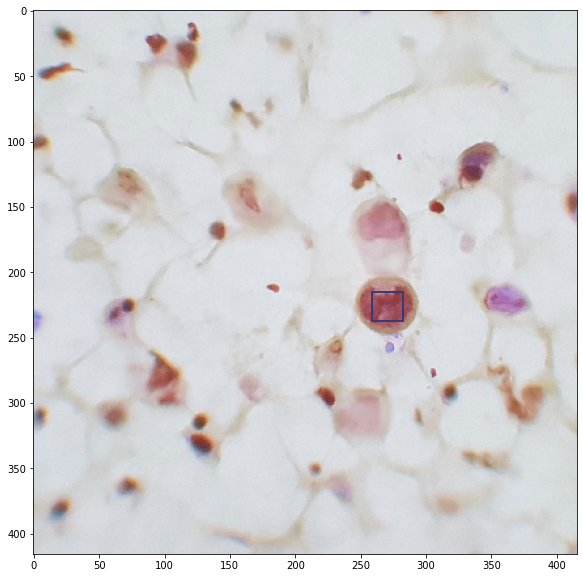

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:58<00:00, 63.59it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.629883%
Obj accuracy is: 90.673050%


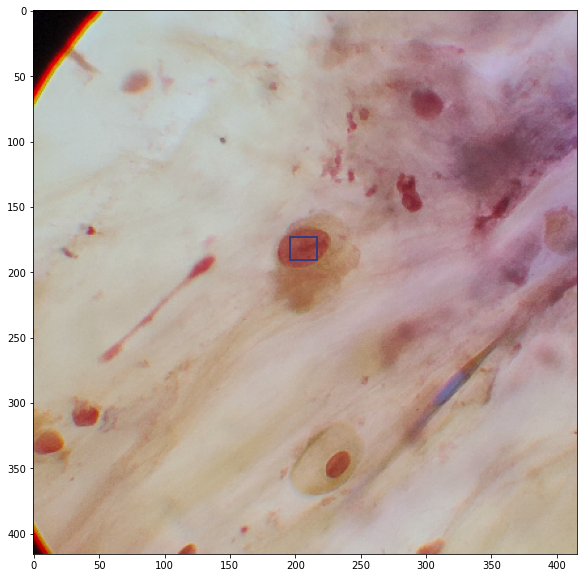

<Figure size 720x720 with 0 Axes>

100%|██████████| 3744/3744 [00:58<00:00, 63.46it/s]

Class accuracy is: 100.000000%
No obj accuracy is: 99.631233%
Obj accuracy is: 91.092072%


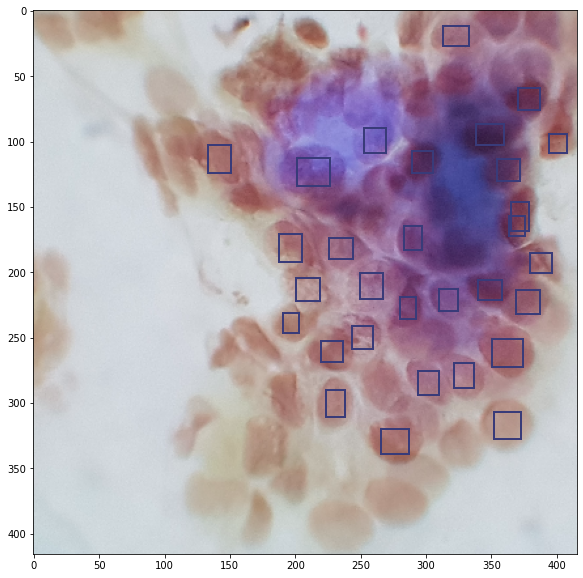

<Figure size 720x720 with 0 Axes>

100%|██████████| 468/468 [03:41<00:00,  2.12it/s, loss=0.539]


In [14]:
for epoch in range(config.NUM_EPOCHS):
    #plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    model.train()
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    if epoch > 0 and epoch % 5 == 0:
        model.eval()
        check_class_accuracy(model, test_loader, threshold=config
                             
                             
                             
                             
                             
                             ls
                             CONF_THRESHOLD)
        plot_couple_examples(model, test_loader, 0.5, 0.4, scaled_anchors)
#         pred_boxes, true_boxes = get_evaluation_bboxes(
#             test_loader,
#             model,
#             iou_threshold=config.NMS_IOU_THRESH,
#             anchors=config.ANCHORS,
#             threshold=config.CONF_THRESHOLD,
#         )
#         mapval = mean_average_precision(
#             pred_boxes,
#             true_boxes,
#             iou_threshold=config.MAP_IOU_THRESH,
#             box_format="midpoint",
#             num_classes=config.NUM_CLASSES,
#         )
#         print(f"MAP: {mapval.item()}")


In [15]:
# saved_dir = '../trained_model/'
# state = {
#     'epoch': 90,
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
# #     'scheduler' : scheduler.state_dict()
# }
# torch.save(state, saved_dir + 'epoch_' + str(90) +'_model.pt')